In [1]:
# jupyter nbconvert HW5.ipynb --TagRemovePreprocessor.remove_cell_tags='{"remove-cell"}' --to pdf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline
%config InlineBackend.figure_format = 'png'

from pylab import rcParams
rcParams.update({"axes.grid" : True})
rcParams['figure.figsize'] = (6,4)
rcParams['lines.linewidth'] = 1
rcParams['image.cmap'] = 'Greys'
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['font.weight'] = 400
rcParams['font.size'] = 9
rcParams['xtick.color'] = '#111111'
rcParams['ytick.color'] = '#111111'
rcParams['grid.color'] = '#dddddd'
rcParams['grid.linestyle'] = '-'
rcParams['grid.linewidth'] = 0.5
rcParams['axes.titlesize'] = 12
rcParams['axes.titleweight'] = 500
rcParams['axes.labelsize'] = 10
rcParams['axes.labelweight'] = 400
rcParams['axes.linewidth'] = 0.5
rcParams['axes.edgecolor'] = [.25,.25,.25]

## From Linear to Nonlinear

We use the U.S. birth rate data as an example. The data records birth rates from 1917 to 2003. The birth rate trend is obviously very nonlinear. 

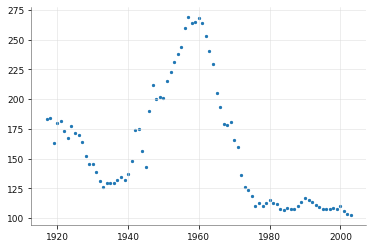

In [2]:
birthrates = np.array(pd.read_csv('./birthrates.csv'))
x = birthrates[:,0]
y = birthrates[:,1]
plt.scatter(x, y, s=5)
plt.show()

It might be interesting to fit a linear regression with high order polynomials to approximate this curve. This can be carried out using the `poly()` function, which calculates all polynomials up to a certain power. Please note that this is a more stable method compared with writing out the powers such as `I(Year^2)`, `I(Year^3)` etc because the `Year` variable is very large, and is numerically unstable. 

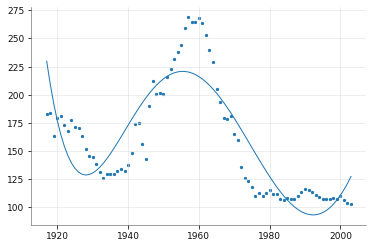

In [3]:
mymodel = np.poly1d(np.polyfit(x, y, 5))

plt.scatter(x, y, s=5)
plt.plot(x, mymodel(x))
plt.show()

These fittings do not seem to perform very well. How about we take a different approach, model the curve locally. Well, we know there is an approach that works in a similar way -- $k$NN. But we will try something new. Let's first divide the year range into several non-overlapping intervals, say, every 10 years. Then we will estimate the regression coefficients within each interval by averaging the observations, just like $k$NN. The only difference is that for prediction, we do not recalculate the neighbors anymore, just check the intervals. 

```{r fig.width=5.5, fig.height=4, out.width = '45%'}
    par(mar = c(2,2,2,0))

    mybasis = matrix(NA, nrow(birthrates), 8)
    for (l in 1:8)
        mybasis[, l] = birthrates$Year*(birthrates$Year >= 1917 + l*10)
        
    lmfit <- lm(birthrates$Birthrate ~ ., data = data.frame(mybasis))
    plot(birthrates, pch = 19, col = "darkorange")
    lines(birthrates$Year, lmfit$fitted.values, lty = 1, type = "s", col = "deepskyblue", lwd = 2)
    title("Histgram Regression")
```

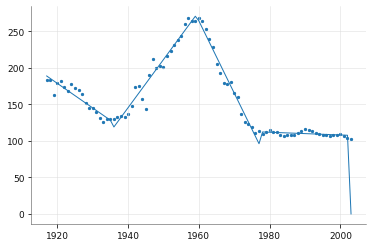

In [4]:
knots = [1936, 1960, 1978, 2003]
basis = np.array([
    (x < knots[0]),
    (x >= knots[0]) * (x < knots[1]),
    (x >= knots[1]) * (x < knots[2]),
    (x >= knots[2]) * (x < knots[3]),
    x*(x < knots[0]),
    x*(x >= knots[0]) * (x < knots[1]),
    x*(x >= knots[1]) * (x < knots[2]),
    x*(x >= knots[2]) * (x < knots[3])
]).T
OLS_model = sm.OLS(y,basis).fit()
plt.plot(x, basis @ OLS_model.params)
plt.scatter(x, y, s=5)
plt.show()

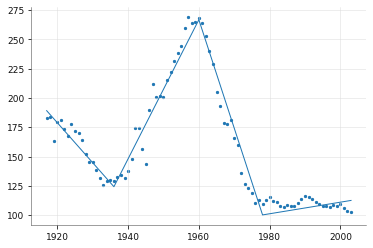

In [5]:
knots = [1936, 1960, 1978, 2003]
basis = np.array([
    np.ones(len(x)),
    x,
    np.abs(x-knots[0]),
    np.abs(x-knots[1]),
    np.abs(x-knots[2])
]).T

OLS_model = sm.OLS(y,basis).fit()
plt.plot(x, basis @ OLS_model.params)
plt.scatter(x, y, s=5)
plt.show()

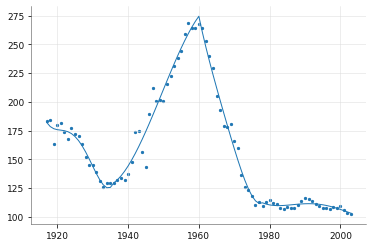

In [6]:
knots = [1936, 1960, 1978, 2003]
basis = np.array([
    np.ones(len(x)),
    x,
    np.abs(x-knots[0]),
    np.abs(x-knots[1]),
    np.abs(x-knots[2])
]).T

from sklearn.preprocessing import PolynomialFeatures
polynomial_features= PolynomialFeatures(degree=4)
xp = polynomial_features.fit_transform(basis)
xp.shape

OLS_model = sm.OLS(y,xp).fit()
plt.plot(x, xp @ OLS_model.params)
plt.scatter(x, y, s=5)
plt.show()